# Experiment 1 Fixed Tilt with Varying Parameters

This journal supports the process of designing a solar panel configuration to appropriately represent and Agripv setup with varying parameters.
The goal of this journal is to test and compare the irradiance values when changing certain parameters. Only one paramater is changed at a time. 
The journal also uses these Radiance results to compare them to results calculated for the same parameters for bifacialVF, calculating accuracy as a percent difference.
(<a href="http://localhost:8888/notebooks/Documents/GitHub/bifacialvf/docs/tutorials/Bifacialvf_Experiment_1.ipynb">Bifacialvf_Experiment_1</a>)

Details:
*	Location: lat = 32.25, -110.9 (Tuscon, Arizona)
*	Racking: Fixed-tilt panels
*	Panel size: 1m x 2m                                    
*	Analysis variations:
<ul> <li> a.	Panel tilt: would like to examine angles 20,30 degrees. 
<li> b.	Clearance Height: would like to look at multiple heights ([0.25, 0.5, 0.75, 1, 1.5, 2 m) </li> 
<li> c.	Ground Coverage Ratio (GCR) (E/W): would like to look at multiple GCRs (0.28, 0.33, 0.4, 0.6) </li> 
<li> d. Ygaps: Looking at multiple Ygaps in the modules. (0,.1,.2,.3,.5,1) </li>


In [26]:
import bifacial_radiance
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bifacialvf

In [27]:
testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' /  'Experiment_1')
if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
resultsfolder = os.path.join(testfolder, 'results')

### General Parameters and Variables

In [29]:
ft2m = 0.3048
lat = 32.25
lon = -110.9  #Lat and Long for Tuscon Arizona           

# Constants
azimuth = 180 #cycling through 3 different azimuths                 
albedo = 0.31  # Changed from 0.31 for test 6/9/22
x = 1
y = 2 
xgap =  0.02
ygap = 0 # Meters
# D (meters)is a variable that represents the spacing between rows, not-considering the collector areas.
D = 2.8        
nMods = 20
nRows = 7
numpanels = 1
moduletype = 'test-module' #Need to make sure this is right module
hpc = False
sim_general_name = 'Rad_Experiment1'
CW = y * numpanels
    
#Arrays for loops
tilts = [20,30]  
clearance_heights = np.array([0.25,0.5,0.75,1,1.5,2]) # height/ collector width
GCRs = [0.28,0.33,0.4,0.6]
ygaps = [0,.1,.2,.3,.5,1]

#Defaults
tilt_def = tilts[0]
clearance_height_def = clearance_heights[2]
GCR_def = GCRs[1]
pitch_def = CW/GCR_def



## Create Geometry using gendaylit and view

In [ ]:
# This allows us to view how our setup looks before generating the cumulative sky and running the simulation.
# Exit out of the popup to be able to comntinue.
demo = bifacial_radiance.RadianceObj(sim_general_name,str(testfolder)) 
demo.setGround(albedo)
epwfile = demo.getEPW(lat,lon)  
metdata=demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime)
timestamp = metdata.datetime.index(pd.to_datetime('2003-06-01 13:00:0 -8'))
demo.gendaylit(timestamp)  # Use this to simulate only one hour at a time.
azimuth_test = 180
pitch = pitch_def
sim_name = sim_general_name+'_az_'+str(round(azimuth,1))
module = demo.makeModule(name=moduletype, x=x, y=y,numpanels = numpanels, xgap=xgap, ygap=ygap)
sceneDict = {'tilt':tilt_def,'pitch':pitch,'clearance_height':clearance_height_def,'azimuth':azimuth_test,'nMods': nMods,'nRows': nRows}
scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
octfile = demo.makeOct(demo.getfilelist()) 
!rvu -vf views\front.vp -e .01 -pe 0.4 -vp 3.5 -20 22 Rad_Experiment1.oct

## Generate Sky for a month

In [31]:
starttime =pd.to_datetime('2021-6-01 01:00:0')
endtime = pd.to_datetime('2021-6-30 23:00:0')
demo = bifacial_radiance.RadianceObj(sim_general_name,str(testfolder)) 
demo.setGround(albedo)
epwfile = demo.getEPW(lat,lon)  
demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime, coerce_year = 2021) # Name and path
demo.genCumSky()


path = C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1
Loading albedo, 1 value(s), 0.310 avg
1 nonzero albedo values.
Getting weather file: USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loaded  EPWs\metdata_temp.csv
message: There were 418 sun up hours in this climate file
Total Ibh/Lbh: 0.000000


'skies\\cumulative.rad'

## Setup length, width and sensors for scene

In [35]:
# Parameters for scene size and sensor starts
sensorsx_fb = [1,1]
sensorsy_fb = [4,6*numpanels]
sensorsx_gb = [1,1] 
sensorsy_gb = [100,101] 

## Begining of Experiment. Part 1: Varying tilt

In [ ]:
module = demo.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for ti in range (0, len(tilts)):
    #Build scene and run raytracing for both tilts
    tilt = tilts[ti]
    length = pitch_def*nRows+(y* np.cos(np.radians(tilt)))+2
    yinc = pitch_def/(sensorsy_gb[0]-1)
    writefiletitle = os.path.join(testfolder, 'Results_Test_Tilt_'+str(tilt)+'.csv')
    sim_name = sim_general_name+'_tilt_'+str(tilt)
    sceneDict = {'tilt':tilt,'pitch':pitch_def,'clearance_height':clearance_height_def,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)
    

## Ground Irradiance Tilt Comparison Graphs

In [ ]:
for ti in range (0, len(tilts)):
    tilt = tilts[ti]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_'+str(tilt)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2
    #Flip the table that contains the data
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=tilt)
    plt.title('Bifacial Radiance')
    plt.ylim([0, 260])
    #Based on the length of the module and the pitch, in this analysis the module is located from 0-33% on the axis.
    #This is marked out in green.
    plt.axvspan(0, 33, alpha=.1, color='green')
    plt.ylim([0, 260])
    plt.xlim([0, 100])
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.legend()
   

## Find percent differences betweem Radiance and VF

In [ ]:
# Using full width half hight calculateions to find the midpoint of both Radiance and VF graphs. Then averaging the points below the midpoint
# and comparing them to find percent differences.
for ti in range (0, len(tilts)):
    tilt = tilts[ti]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_'+str(tilt)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 200,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >220000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    print('Rad Mid',Mid)
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    Radave = np.mean(line['Wm2Front'])
    print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_Tilt_'+str(tilt)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Jun'] >220000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Jun'])
    #Find Minimum of plot
    minpointvf=np.min(df['Jun'])
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    print('VF mid',Midvf)
    Midrvf = Midvf + minpointvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Jun'] < Midrvf]
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Jun'])
    print('Average VF is',VFave)

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For tilt =',tilt,'difference is',Pdif,'%')

## Back of Module Comparison

In [ ]:
## Compares the irradiance that reaches the back of the module for the two tilts
for ti in range (0, len(tilts)):
    tilt = tilts[ti]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_'+str(tilt)+'_Ground_Analysis_Back.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)

    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Back",}, inplace = True) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100
    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Back']/1000, label=tilt)
    plt.title('Bifacial Radiance Back of Module tilt comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.legend()

##  Part 2: Varying Clearance Height

In [36]:
module = demo.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for ch in range (0, len(clearance_heights)):
    #Build scene and run raytracing for all clearance heights
    clearance_height = clearance_heights[ch]
    length = pitch_def*nRows+(y* np.cos(np.radians(tilt_def)))+2
    yinc = pitch_def/(sensorsy_gb[0]-1)
    writefiletitle = os.path.join(testfolder, 'Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
    sim_name = sim_general_name+'_ClearanceHeight_'+str(clearance_height)
    sceneDict = {'tilt':tilt_def,'pitch':pitch_def,'clearance_height':clearance_height,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)



Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Front
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Back.csv
Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_ClearanceHeight_0.5_Module_Analysis_Front
Linescan in process: Rad_Expe

## Ground Irradiance Clearance Height Comparison

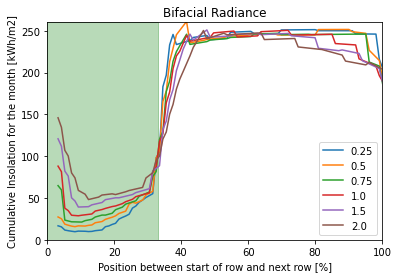

In [37]:
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    module_end = (2/pitch_def)*100 #Percentage between rows where the module ends
    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=clearance_height)
    plt.ylim([0, 260])
    plt.xlim([0, 100])
    plt.title('Bifacial Radiance')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.axvspan(0, module_end, alpha=.05, color='green')
    plt.legend()

In [ ]:
print(df)

In [ ]:
#Experiment with averageing
module_end = 2
module_endvf = (2/pitch_def)*100
# Using full width half hight calculateions to find the midpoint of both Radiance and VF graphs. Then averaging the points below the midpoint
# and comparing them to find percent differences.
from bifacialvf import loadVFresults
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 220,000
    modulerad = data_line_f.loc[data_line_f['y']+1 <module_end]
    #Average rows for average of max
    Radave = np.mean(modulerad['Wm2Front'])
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    #line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    #Radave = np.mean(line['Wm2Front'])
    #print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    #modulevf = df.loc[df['Jun'] < 120000]
    moduleJ = df['Jun']
    module_test = moduleJ.iloc[:33]
    #Average rows for average of max
    Vfave = np.mean(module_test)
    #Find Minimum of plot
    #minpointvf=np.min(df['Jun'])
    #Find midpoint of pot
    #Midvf = (maxavevf-minpointvf)/2
    #Midrvf = minpointvf + Midvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    #linevf = df.loc[df['Jun'] < Midrvf]
    #Average these for the average for Radiance
    #VFave = np.mean(linevf['Jun'])
    #print('Average VF is',VFave)

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For Clearance Height =',clearance_height,'difference is',Pdif,'%')

In [ ]:
print(modulerad)

## VF and Radiance Clearance Height Percent Differences

In [215]:
# Using full width half hight calculateions to find the midpoint of both Radiance and VF graphs. Then averaging the points below the midpoint
# and comparing them to find percent differences.
from bifacialvf import loadVFresults
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 220,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >200000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    Radave = np.mean(line['Wm2Front'])
    #print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Jun'] >200000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Jun'])
    #Find Minimum of plot
    minpointvf=np.min(df['Jun'])
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    Midrvf = minpointvf + Midvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Jun'] < Midrvf]
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Jun'])
    #print('Average VF is',VFave)
    ranges = abs(Radave - VFave)/1000

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For Clearance Height =',clearance_height,'difference is',Pdif,'%, Rad:',Radave,'VF:',VFave, ranges)

For Clearance Height = 0.25 difference is 7.68052937161505 %, Rad: 28167.306258064527 VF: 26083.915738125786 2.083390519938741
For Clearance Height = 0.5 difference is 22.39369281591834 %, Rad: 34457.01258064517 VF: 27517.78921225681 6.939223368388361
For Clearance Height = 0.75 difference is 26.99369992243024 %, Rad: 44396.38312499999 VF: 33837.30025946647 10.55908286553352
For Clearance Height = 1.0 difference is 28.40652430052782 %, Rad: 50638.65468749999 VF: 38042.970922934415 12.595683764565576
For Clearance Height = 1.5 difference is 25.901150672043304 %, Rad: 61141.719375 VF: 47121.065817739036 14.020653557260964
For Clearance Height = 2.0 difference is 22.541633020643133 %, Rad: 71386.24062499999 VF: 56924.56514387499 14.461675481124999


In [223]:
type(groundIrrads.index)

pandas.core.indexes.datetimes.DatetimeIndex

## Back of Module Clearance Height Comparison

In [ ]:
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Back.csv'
    (data2, metadata) = loadVFresults(Radiance_File)

    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Back",}, inplace = True) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100
    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Back']/1000, label=clearance_height)
    plt.title('Bifacial Radiance Back of Module Clearance_Height comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.legend()

## Part 3 Varying GCR

In [ ]:
module = demo.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for gc in range (0, len(GCRs)):
    #Build scene and run raytracing for all GCrs
    GCR = GCRs[gc]
    pitch = CW/GCR
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    yinc = pitch/(sensorsy_gb[0]-1) 
    writefiletitle = os.path.join(testfolder, 'Results_Test_GCR_'+str(GCR)+'.csv')
    sim_name = sim_general_name+'_Oct_GCR_'+str(GCR)
    sceneDict = {'tilt':tilt_def,'pitch':pitch,'clearance_height':clearance_height_def,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)

## Ground Irradiance GCR Comparison Graphs

In [ ]:
for gc in range (0, len(GCRs)):
    GCR = GCRs[gc]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Oct_GCR_'+str(GCR)+'_Ground_Analysis_Front.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    pitch = CW/GCR
    module_end = (2/pitch)*100 #Percentage between rows where the module ends)
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    print(length)
    yinc = -length/(sensorsy_gb[0]-1)
    
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch)*100

    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=GCR)
    plt.ylim([0, 260])
    plt.xlim([0, 100])
    plt.title('Bifacial Radiance')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()

## VF and Radiance GCR Percent Difference

In [ ]:
for gc in range (0, len(GCRs)):
    GCR = GCRs[gc]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_'+str(GCR)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 210,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >210000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    Radave = np.mean(line['Wm2Front'])
    #print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_GCR_'+str(GCR)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Jun'] >210000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Jun'])
    #Find Minimum of plot
    minpointvf=np.min(df['Jun'])
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    Midrvf = Midvf + minpointvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Jun'] < Midrvf]
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Jun'])
    #print('Average VF is',VFave)

    Pdif = (Radave-VFave)/((Radave+VFave)/2)*100
    print('For GCR =',GCR,'difference is',Pdif,'%')

## Back of Module GCR Comparison

In [ ]:
for gc in range (0, len(GCRs)):
    GCR = GCRs[gc]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_'+str(GCR)+'_Ground_Analysis_Back.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    pitch = CW/GCR
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    print(length)
    yinc = -length/(sensorsy_gb[0]-1)
    
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100

    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=GCR)
    plt.title('Bifacial Radiance Back of Module GCR Comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()

## Part 4 Varying Y Gaps

In [ ]:
#Change module orientation to be landscape
xl = 2
yl = 1 
ygaps = [0,.1,.2,.3,.5,1]
numpanels_l = 2
for yg in range (0, len(ygaps)):
     #Build scene and run raytracing for all Ygaps
    ygap = ygaps[yg]
    module = demo.makeModule(name=moduletype, x=xl, y=yl,numpanels = numpanels_l, xgap=xgap, ygap=ygap)
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    pitch = CW/GCR_def
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    yinc = pitch/(sensorsy_gb[0]-1) 
    writefiletitle = os.path.join(testfolder, 'Results_Test_Ygap_'+str(ygap)+'.csv')
    sim_name = sim_general_name+'_Oct_Ygap_'+str(ygap)
    sceneDict = {'tilt':tilt_def,'pitch':pitch,'clearance_height':clearance_height_def,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb) #Change x and y sensors to match if you want to autogenerate front/back ratio
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)

## Compare ground Irradiances graph

In [ ]:
xl = 2
yl = 1 
numpanels_l = 2
for yg in range (0, len(ygaps)):
    ygap = ygaps[yg]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Oct_Ygap_'+str(ygap)+'_Ground_Analysis_Front.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    pitch = CW/GCR_def
    
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)

    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch)*100

    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=ygap)
    plt.ylim([0, 150])
    plt.xlim([0, 100])
    plt.title('Bifacial Radiance YGap Comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()

## Average Radiance and VF YGap comparison

In [ ]:
# The Ygap variation in Radiance is compared to the transmission factor in VF
xl = 2
yl = 1 
ygaps = [0,.1,.2,.3,.5,1]
numpanels_l = 2
for yg in range (0, len(ygaps)):
    ygap = ygaps[yg]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_'+str(ygap)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 220,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >220000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #print(line)
    #Find last point
    last = line.iloc[0]
    #return row number of the last point
    lp = line[line['y'] == last['y']].index[0]
    #print(lp)
    #Make matrix of all points from 0 to last point
    merge = data_line_f.iloc[lp:]
    #print(merge)
    #Average these for the average for Radiance
    Radave = np.mean(merge['Wm2Front'])
    #print('Average Radiance for', ygap,'is',Radave)

    #Do the Same for Bifacial VF
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    AA = yl*numpanels_l #Area of module that light hits
    transFactor = 1 - (AA/CW) # TransmissionFactor(open area fraction)
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_TFactor_'+str(transFactor)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Jun'] >220000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Jun'])
    #print('Max VF is',maxavevf)
    #Find Minimum of plot
    minpointvf=np.min(df['Jun'])
    #print('Min VF is',minpointvf)
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    Midrvf = Midvf + minpointvf
    #print('Midpoint is',Midvf)
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Jun'] < Midrvf]
    #print(linevf)
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Jun'])
    #print('Average VF is',VFave)

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For Ygap =',ygap,'difference is',Pdif,'%')

## Compare Back of Module

<a id='step5c'></a>

In [ ]:
for yg in range (0, len(ygaps)):
    ygap = ygaps[yg]
    from bifacialvf import loadVFresults
    #Change to File Name
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_'+str(ygap)+'_Ground_Analysis_Back.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    pitch = CW/GCR_def
    
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Back",}, inplace = True)
    
    yshift = data_line_f['y'] + abs(float(data_line_f['y'].iloc[[0]]))# Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100

    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Back']/1000, label=ygap)
    plt.title('Bifacial Radiance Back of Module Y Gap Comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()

## Create Dataframe for comparing Radiance and VF clearance heights and export as cv

In [39]:
folder = r'C:\\Users\\jjones\\Documents\\GitHub\\bifacial_radiance\\bifacial_radiance\\TEMP\\Experiment_1'
dataRad = {}
dataVF = {}
from bifacialvf import loadVFresults
Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Oct_ClearanceHeight_0.25_Ground_Analysis_Front.csv'
(data2, metadata) = loadVFresults(Radiance_File)
data_line_f = data2
#data_line_f = data_line[::-1].reset_index(drop = True) 
data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True) 
yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
dataRad = {'y' :yshift}
ystep = pitch_def/100
y_axis = np.arange(0,pitch_def,ystep)
dataVF = {'y':y_axis}
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    cheight = str(clearance_height)
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line_f = data2
    #data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: cheight,}, inplace = True) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    dataRad[cheight]=(data_line_f[cheight]) 

    VF_File = r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv'
    
    (data, metadata) = loadVFresults(VF_File)
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    dataVF[cheight]=(df['Jun'])
    #ystep = (yshift/pitch_def)*100
    #module_end = (2/pitch_def)*100 #Percentage between rows where the module ends
    #plt.figure(1)
    #Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=clearance_height)
    #plt.ylim([0, 260])
    #plt.xlim([0, 100])
    #plt.title('Bifacial Radiance')
    #plt.xlabel('Position between start of row and next row [%]')
    #plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    #plt.axvspan(0, module_end, alpha=.05, color='green')
    #plt.legend()
#dataRadf = np.flipud(dataRad)
Raddf = pd.DataFrame(dataRad)
VFdf = pd.DataFrame(dataVF)
Rad = Raddf.to_csv(path_or_buf =r'C:\\Users\\jjones\\Documents\\GitHub\\bifacial_radiance\\bifacial_radiance\\TEMP\\Experiment_1\Rad.csv',index=False)
VF = VFdf.to_csv(path_or_buf =r'C:\\Users\\jjones\\Documents\\GitHub\\bifacial_radiance\\bifacial_radiance\\TEMP\\Experiment_1\VF.csv',index=False)

## Run Clearance Height Simulation for 1 hour using gendaylit

In [59]:
# This allows us to view how our setup looks before generating the cumulative sky and running the simulation.
# Exit out of the popup to be able to comntinue.
demos = bifacial_radiance.RadianceObj(sim_general_name,str(testfolder)) 
demos.setGround(albedo)
epwfile = demos.getEPW(lat,lon)  
metdata=demos.readWeatherFile(epwfile, starttime=starttime, endtime=endtime,coerce_year = 2021)
timestamp = metdata.datetime.index(pd.to_datetime('2021-06-01 13:00:0 -7'))
demos.gendaylit(timestamp)  # Use this to simulate only one hour at a time.
#azimuth_test = 180
#pitch = pitch_def
#sim_name = sim_general_name+'_az_'+str(round(azimuth,1))
#module = demo.makeModule(name=moduletype, x=x, y=y,numpanels = numpanels, xgap=xgap, ygap=ygap)
#sceneDict = {'tilt':tilt_def,'pitch':pitch,'clearance_height':clearance_height_def,'azimuth':azimuth_test,'nMods': nMods,'nRows': nRows}
#scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
#octfile = demo.makeOct(demo.getfilelist()) 

path = C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1
Loading albedo, 1 value(s), 0.310 avg
1 nonzero albedo values.
Getting weather file: USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos


'skies\\sky2_32.17_-110.88_2021-06-01_1300.rad'

In [60]:
module = demos.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for ch in range (0, len(clearance_heights)):
    #Build scene and run raytracing for all clearance heights
    clearance_height = clearance_heights[ch]
    length = pitch_def*nRows+(y* np.cos(np.radians(tilt_def)))+2
    yinc = pitch_def/(sensorsy_gb[0]-1)
    writefiletitle = os.path.join(testfolder, 'Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
    sim_name = sim_general_name+'_ClearanceHeight_lit_'+str(clearance_height)
    sceneDict = {'tilt':tilt_def,'pitch':pitch_def,'clearance_height':clearance_height,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demos.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demos.makeOct(demos.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demos.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demos.makeOct(demos.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)


Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_ClearanceHeight_lit_0.25_Module_Analysis_Front
Linescan in process: Rad_Experiment1_ClearanceHeight_lit_0.25_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_ClearanceHeight_lit_0.25_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_ClearanceHeight_lit_0.25_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_ClearanceHeight_lit_0.25_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_ClearanceHeight_lit_0.25_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_ClearanceHeight_lit_0.25_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_ClearanceHeight_lit_0.25_Ground_Analysis_Back.csv
Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_ClearanceHeight_lit_0.5_Module_Analysis

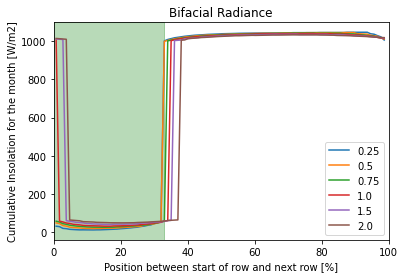

In [82]:
# Plot Radiance values simulated for 1 hour
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_lit_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True) 
    yshift = data_line_f['y'] + 0.85 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    module_end = (2/pitch_def)*100 #Percentage between rows where the module ends
    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front'], label=clearance_height)
    #plt.ylim([0, 260])
    plt.xlim([0, 100])
    plt.title('Bifacial Radiance')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [W/m2]')
    plt.axvspan(0, module_end, alpha=.05, color='green')
    plt.legend()

## Compare Radiance and VF for 1 hour

In [64]:
# Using full width half hight calculateions to find the midpoint of both Radiance and VF graphs. Then averaging the points below the midpoint
# and comparing them to find percent differences.
from bifacialvf import loadVFresults
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_lit_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 220,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >900]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    Radave = np.mean(line['Wm2Front'])
    #print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    dates = '2021-06-01 13:00:00-07:00'
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='H')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.

    topvf = df.loc[df[dates] >900]
    #Average rows for average of max
    maxavevf = np.mean(topvf[dates])
    #Find Minimum of plot
    minpointvf=np.min(df[dates])
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    Midrvf = minpointvf + Midvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df[date] < Midrvf]
    #Average these for the average for Radiance
    VFave = np.mean(linevf[dates])
    #print('Average VF is',VFave)

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For Clearance Height =',clearance_height,'difference is',Pdif,'%, Rad:',Radave,'VF:',VFave)

For Clearance Height = 0.25 difference is 61.344965802866646 %, Rad: 21.40326124999999 VF: 11.355374347587206
For Clearance Height = 0.5 difference is 63.599163111557466 %, Rad: 28.155208749999996 VF: 14.569067636392727
For Clearance Height = 0.75 difference is 66.4106717512016 %, Rad: 34.70264757575758 VF: 17.40134262500443
For Clearance Height = 1.0 difference is 66.77891250978575 %, Rad: 39.55683121212122 VF: 19.75345060885326
For Clearance Height = 1.5 difference is 67.84391728273849 %, Rad: 47.020730000000015 VF: 23.200360666568308
For Clearance Height = 2.0 difference is 71.38291441594643 %, Rad: 53.50509545454544 VF: 25.357784428214764


In [49]:
date = '2021-06-01 13:00:00-07:00'
(data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
#Work with data in resultfile
data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
df = groundIrrads.groupby([pd.Grouper(freq='H')]).sum().T

## Comparison Graphs of Radiance and VF for Clearance Height for June

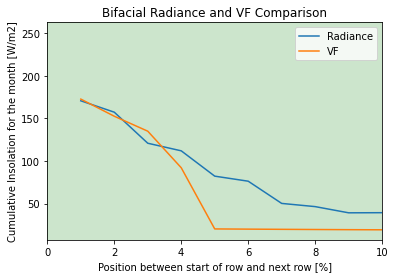

In [182]:
compare = {}
x_axis = list(range(1,101))
from bifacialvf import loadVFresults
Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_1.5_Ground_Analysis_Front.csv'
#(data2, metadata) = loadVFresults(Radiance_File)
data2 = pd.read_csv(Radiance_File)
data_line = data2
data_line_f = data_line
#data_line_f = data_line[::-1].reset_index(drop = True) 
data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True) 
yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
ystep = (yshift/pitch_def)*100
module_end = (2/pitch_def)*100 #Percentage between rows where the module ends
compare['Rad'] = data_line_f['Wm2Front']
plt.figure(1)
Radiance = plt.plot(x_axis,data_line_f['Wm2Front']/1000, label='Radiance')
#plt.ylim([0, 260])
#plt.xlim([0, 100])
#plt.title('Bifacial Radiance vs VF')
#plt.xlabel('Position between start of row and next row [%]')
#plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
#plt.axvspan(0, module_end, alpha=.05, color='green')
#plt.legend()
# Work with VF data
VFfile = r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_ClearanceHeight_1.5.csv'
#Load the results from the resultfile
(data, metadata) = loadVFresults(VFfile)
#Work with data in resultfile
data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

               df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
               df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)

compare['vf'] = df['Jun']
VF = plt.plot(x_axis, df['Jun']/1000, label='VF')
module_end = (2/pitch_def)*100 #Percentage between rows where the module ends)
plt.axvspan(0, module_end, alpha=.2, color='green')
#plt.ylim([0, 260])
plt.xlim([0, 10])
plt.title('Bifacial Radiance and VF Comparison')
plt.xlabel('Position between start of row and next row [%]')
plt.ylabel('Cumulative Insolation for the month [W/m2]')
plt.legend()

## Graph of Radiance/VF Ratio vs Position

The average ratio for clearance height 0.25 is 1.2239080890895602
The average ratio for clearance height 0.5 is 1.216237718782251
The average ratio for clearance height 0.75 is 1.1585423275263746
The average ratio for clearance height 1.0 is 1.1662372647830401
The average ratio for clearance height 1.5 is 1.169635785871115
The average ratio for clearance height 2.0 is 1.1407009950330993


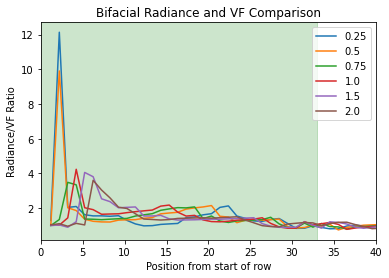

In [191]:
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    data2 = pd.read_csv(Radiance_File)
    data_line = data2
    data_line_f = data_line 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    module_end = (2/pitch_def)*100 #Percentage between rows where the module ends
    plt.figure(1)
    #Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label='Radiance')
    #plt.ylim([0, 260])
    #plt.xlim([0, 100])
    #plt.title('Bifacial Radiance vs VF')
    #plt.xlabel('Position between start of row and next row [%]')
    #plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    #plt.axvspan(0, module_end, alpha=.05, color='green')
    #plt.legend()
    # Work with VF data
    VFfile = r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv'
    #Load the results from the resultfile
    (data, metadata) = loadVFresults(VFfile)
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                   df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                   df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)

    x_axis = list(range(1,99))
    ratio = data_line_f['Wm2Front']/df['Jun'] 
    VF = plt.plot(ystep, ratio, label = clearance_height)
    mean = np.mean(ratio)
    print('The average ratio for clearance height',clearance_height,'is',mean)
module_end = (2/pitch_def)*100 #Percentage between rows where the module ends)
plt.axvspan(0, module_end, alpha=.2, color='green')
#plt.ylim([0, 4])
plt.xlim([0, 40])
plt.title('Bifacial Radiance and VF Comparison')
plt.xlabel('Position from start of row')
plt.ylabel('Radiance/VF Ratio')
plt.legend()

## Graph with Radiance on X axis and VF on Y axis

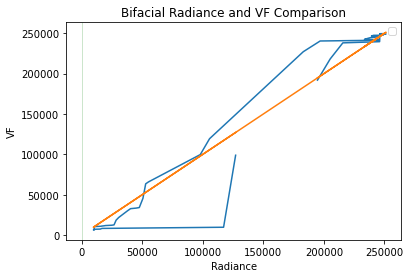

In [184]:
from bifacialvf import loadVFresults
Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Front.csv'
data2 = pd.read_csv(Radiance_File)
data_line = data2
data_line_f = data_line 
data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True) 
yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
ystep = (yshift/pitch_def)*100
module_end = (2/pitch_def)*100 #Percentage between rows where the module ends
#Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label='Radiance')
#plt.ylim([0, 260])
#plt.xlim([0, 100])
#plt.title('Bifacial Radiance vs VF')
#plt.xlabel('Position between start of row and next row [%]')
#plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
#plt.axvspan(0, module_end, alpha=.05, color='green')
#plt.legend()
# Work with VF data
VFfile = r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_ClearanceHeight_0.25.csv'
#Load the results from the resultfile
(data, metadata) = loadVFresults(VFfile)
#Work with data in resultfile
data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

               df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
               df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)

plt.figure(1)
x_axis = list(range(1,99))
ratio = data_line_f['Wm2Front']/df['Jun'] 
VF = plt.plot(data_line_f['Wm2Front'],df['Jun'])
constant = plt.plot(data_line_f['Wm2Front'],data_line_f['Wm2Front'])
module_end = (2/pitch_def)*100 #Percentage between rows where the module ends)
plt.axvspan(0, module_end, alpha=.2, color='green')
#plt.ylim([0, 2])
#plt.xlim([0, 100])
plt.title('Bifacial Radiance and VF Comparison')
plt.xlabel('Radiance')
plt.ylabel('VF')
plt.legend()

In [149]:
comp = pd.DataFrame(compare)
compcsv = comp.to_csv(path_or_buf =r'C:\\Users\\jjones\\Documents\\GitHub\\bifacial_radiance\\bifacial_radiance\\TEMP\\Experiment_1\compare.csv',index=False)


In [185]:
np.mean(ratio)

1.2239080890895602

In [194]:
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    VF_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_lit_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    #Load the results from the resultfile
    from bifacialvf import loadVFresults
    (data, metadata) = loadVFresults(VF_File)
    #Work with data in resultfile
    #data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    date = times[2]
    gg = groundIrrads.loc[date]
    #Calculate midpoint. Use this to figure out where to split table. We'll split at row 33
    mid = 0.5*CW*np.cos(tilt) #This midpoint is at 1m because the tilt is 0
    #will make two seperate tables from the split and then append front split to back split
    splitfront = gg.iloc[:33]
    splitback = gg.iloc[33:]
    full = splitback.append(splitfront)
    #create x axis
    xstep = pitch_def/100
    xaxis = np.linspace(0, pitch_def, num=100, endpoint=True)
    graph = plt.plot(x_axis, full, label=chreg)
    plt.title('Bifacial_VF Comparison of Hub Height '+date)
    plt.xlabel('Meters from middle (m)')
    plt.ylabel('Cumulative Insolation for the month [W/m2]')
plt.legend()
plt.show

AttributeError: 'int' object has no attribute 'replace'

## Experiment for Turning Irradiance --> PAR --> PPFD

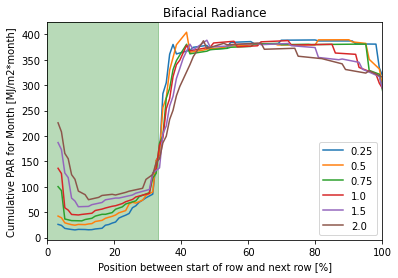

In [204]:
# Global irradiance is calculated in Radiance and VF. Using ratios we can go from global irradiance to photosynthetically
# active radiation and then photosynthetic photon flux density. This is helpful understanding how the light exposure
# will affect plant's growth potentials and rates.
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True) 
    PAR = data_line_f['Wm2Front'] *0.43 # The wavelengths of PAR make up 43-45% of the irradiance spectrum kWh/m2
    # We need to convert to MJ/m2 1 Wh = 0.0036 MJ
    PARMJ = PAR *0.0036
    #Conversion factor for PAR to PPFD is 1 MJ/m2·d =127.79 μmol·m-2·s-1 based on paper from https://www.researchgate.net/publication/328532035_Analysis_of_Light_Environment_Under_Solar_Panels_and_Crop_Layout
    PPFD = PARMJ * 127.79
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    module_end = (2/pitch_def)*100 #Percentage between rows where the module ends
    plt.figure(1)
    Radiance = plt.plot(ystep,PARMJ, label=clearance_height)
    #plt.ylim([0, 260])
    plt.xlim([0, 100])
    plt.title('Bifacial Radiance')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative PAR for Month [MJ/m2*month]')
    plt.axvspan(0, module_end, alpha=.05, color='green')
    plt.legend()


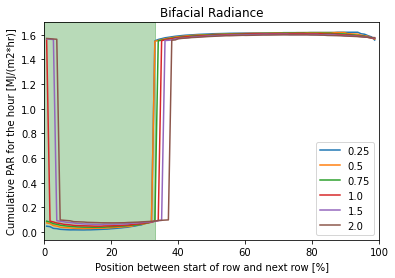

In [205]:
# Plot Radiance values simulated for 1 hour
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_lit_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True) 
    PAR = data_line_f['Wm2Front'] *0.43 # The wavelengths of PAR make up 43-45% of the irradiance spectrum kWh/m2
    # We need to convert to MJ/m2 1 kWh = 0.0036 MJ
    PARMJ = PAR *0.0036
    #Conversion factor for PAR to PPFD is 1 MJ/m2·d =127.79 μmol·m-2·s-1 based on paper from https://www.researchgate.net/publication/328532035_Analysis_of_Light_Environment_Under_Solar_Panels_and_Crop_Layout
    PPFD = PARMJ * 127.79
    yshift = data_line_f['y'] + 0.85 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    module_end = (2/pitch_def)*100 #Percentage between rows where the module ends
    plt.figure(1)
    Radiance = plt.plot(ystep,PARMJ, label=clearance_height)
    #plt.ylim([0, 260])
    plt.xlim([0, 100])
    plt.title('Bifacial Radiance')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative PAR for the hour [MJ/(m2*hr)]')
    plt.axvspan(0, module_end, alpha=.05, color='green')
    plt.legend()
    

## Run Clearance Height Simulation for One Day

In [206]:
starttime =pd.to_datetime('2021-6-01 01:00:0')
endtime = pd.to_datetime('2021-6-01 23:00:0')
demo2 = bifacial_radiance.RadianceObj(sim_general_name,str(testfolder)) 
demo2.setGround(albedo)
epwfile = demo2.getEPW(lat,lon)  
demo2.readWeatherFile(epwfile, starttime=starttime, endtime=endtime, coerce_year = 2021) # Name and path
demo2.genCumSky()

path = C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1
Loading albedo, 1 value(s), 0.310 avg
1 nonzero albedo values.
Getting weather file: USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loaded  EPWs\metdata_temp.csv
message: There were 14 sun up hours in this climate file
Total Ibh/Lbh: 0.000000


'skies\\cumulative.rad'

In [207]:
module = demo2.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for ch in range (0, len(clearance_heights)):
    #Build scene and run raytracing for all clearance heights
    clearance_height = clearance_heights[ch]
    length = pitch_def*nRows+(y* np.cos(np.radians(tilt_def)))+2
    yinc = pitch_def/(sensorsy_gb[0]-1)
    writefiletitle = os.path.join(testfolder, 'Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
    sim_name = sim_general_name+'_ClearanceHeight_day'+str(clearance_height)
    sceneDict = {'tilt':tilt_def,'pitch':pitch_def,'clearance_height':clearance_height,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demo2.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo2.makeOct(demo2.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo2.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo2.makeOct(demo2.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)



Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_ClearanceHeight_day0.25_Module_Analysis_Front
Linescan in process: Rad_Experiment1_ClearanceHeight_day0.25_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_ClearanceHeight_day0.25_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_ClearanceHeight_day0.25_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_ClearanceHeight_day0.25_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_ClearanceHeight_day0.25_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_ClearanceHeight_day0.25_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_ClearanceHeight_day0.25_Ground_Analysis_Back.csv
Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_ClearanceHeight_day0.5_Module_Analysis_Front
Li

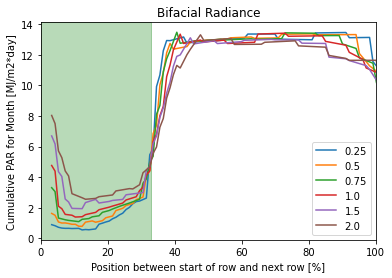

In [208]:
# Global irradiance is calculated in Radiance and VF. Using ratios we can go from global irradiance to photosynthetically
# active radiation and then photosynthetic photon flux density. This is helpful understanding how the light exposure
# will affect plant's growth potentials and rates.
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_day'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True) 
    PAR = data_line_f['Wm2Front'] *0.43 # The wavelengths of PAR make up 43-45% of the irradiance spectrum Wh/m2
    # We need to convert to MJ/m2 1 Wh = 0.0036 MJ
    PARMJ = PAR *0.0036
    #Conversion factor for PAR to PPFD is 1 MJ/m2·d =127.79 μmol·m-2·s-1 based on paper from https://www.researchgate.net/publication/328532035_Analysis_of_Light_Environment_Under_Solar_Panels_and_Crop_Layout
    PPFD = PARMJ * 127.79
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    module_end = (2/pitch_def)*100 #Percentage between rows where the module ends
    plt.figure(1)
    Radiance = plt.plot(ystep,PARMJ, label=clearance_height)
    #plt.ylim([0, 260])
    plt.xlim([0, 100])
    plt.title('Bifacial Radiance')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative PAR for Month [MJ/m2*day]')
    plt.axvspan(0, module_end, alpha=.05, color='green')
    plt.legend()